In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install timm

In [4]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50
import timm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [6]:

dataset_path = "/content/drive/MyDrive/AIUB/CVPR/Final/Paper/Dataset"

# =====================================================
# LOAD IMAGE PATHS & LABELS
# =====================================================
images, labels = [], []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            images.append(os.path.join(root, file))
            labels.append(os.path.basename(root))

unique_labels = sorted(set(labels))
label_map = {label: idx for idx, label in enumerate(unique_labels)}
num_classes = len(unique_labels)

print("Classes:", unique_labels)

Classes: ['Brown Spot', 'Browon Spot', 'Leaf Scaled', 'Rice Blast', 'Rice Tungro', 'Rice Turgro', 'Shath Blight', 'Sheath Blight']


In [7]:
# TRAIN / VALIDATION SPLIT
# =====================================================
train_imgs, val_imgs, train_lbls, val_lbls = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)


In [9]:

# IMAGE TRANSFORMS
# =====================================================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomPerspective(0.2, p=0.5),
    transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# =====================================================
# CUSTOM DATASET
# =====================================================
class RiceDataset(Dataset):
    def __init__(self, paths, labels, transform):
        self.paths = paths
        self.labels = [label_map[l] for l in labels]
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transform(img)
        return img, self.labels[idx]


In [10]:
# DATALOADERS
# =====================================================
batch_size = 32

train_loader = DataLoader(
    RiceDataset(train_imgs, train_lbls, train_transform),
    batch_size=batch_size, shuffle=True, num_workers=2
)

val_loader = DataLoader(
    RiceDataset(val_imgs, val_lbls, val_transform),
    batch_size=batch_size, shuffle=False, num_workers=2
)


In [11]:
# =====================================================
# HYBRID MODEL (ResNet50 + Swin-T)
# =====================================================
class HybridModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.resnet = resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()          # 2048

        self.swin = timm.create_model(
            "swin_tiny_patch4_window7_224",
            pretrained=True,
            num_classes=0                      # 768 pooled
        )

        self.classifier = nn.Sequential(
            nn.Linear(2048 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        r = self.resnet(x)
        s = self.swin(x)
        x = torch.cat((r, s), dim=1)
        return self.classifier(x)


In [12]:
# =====================================================
# TRAINING SETUP
# =====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridModel(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# =====================================================
# TRAIN & VALIDATION FUNCTIONS
# =====================================================
def train_epoch(model, loader):
    model.train()
    loss_sum, correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    return loss_sum / len(loader), correct / total



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 141MB/s]
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [13]:

def validate(model, loader):
    model.eval()
    loss_sum = 0
    preds, gts = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss_sum += criterion(out, y).item()
            preds.extend(out.argmax(1).cpu().numpy())
            gts.extend(y.cpu().numpy())

    acc = accuracy_score(gts, preds)
    precision = precision_score(gts, preds, average="macro", zero_division=0)
    recall = recall_score(gts, preds, average="macro", zero_division=0)
    f1 = f1_score(gts, preds, average="macro", zero_division=0)

    return loss_sum / len(loader), acc, precision, recall, f1


In [14]:
# =====================================================
epochs = 10

train_losses, val_losses = [], []
train_accs, val_accs = [], []
precisions, recalls, f1s = [], [], []

for epoch in range(epochs):
    tl, ta = train_epoch(model, train_loader)
    vl, va, p, r, f1 = validate(model, val_loader)

    scheduler.step()

    train_losses.append(tl)
    val_losses.append(vl)
    train_accs.append(ta)
    val_accs.append(va)
    precisions.append(p)
    recalls.append(r)
    f1s.append(f1)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Acc: {ta:.4f} | Val Acc: {va:.4f} | "
          f"P: {p:.4f} | R: {r:.4f} | F1: {f1:.4f}")


Epoch 1/10 | Train Acc: 0.4287 | Val Acc: 0.5676 | P: 0.4280 | R: 0.4993 | F1: 0.4464
Epoch 2/10 | Train Acc: 0.6889 | Val Acc: 0.6667 | P: 0.7185 | R: 0.6289 | F1: 0.6315
Epoch 3/10 | Train Acc: 0.7410 | Val Acc: 0.7477 | P: 0.7842 | R: 0.7064 | F1: 0.7306
Epoch 4/10 | Train Acc: 0.8450 | Val Acc: 0.7793 | P: 0.7996 | R: 0.7561 | F1: 0.7692
Epoch 5/10 | Train Acc: 0.8846 | Val Acc: 0.7838 | P: 0.8003 | R: 0.7626 | F1: 0.7752
Epoch 6/10 | Train Acc: 0.8880 | Val Acc: 0.7928 | P: 0.8041 | R: 0.7869 | F1: 0.7891
Epoch 7/10 | Train Acc: 0.8982 | Val Acc: 0.7883 | P: 0.8017 | R: 0.7846 | F1: 0.7868
Epoch 8/10 | Train Acc: 0.9027 | Val Acc: 0.7928 | P: 0.8077 | R: 0.7875 | F1: 0.7916
Epoch 9/10 | Train Acc: 0.8959 | Val Acc: 0.7928 | P: 0.8041 | R: 0.7869 | F1: 0.7891
Epoch 10/10 | Train Acc: 0.9016 | Val Acc: 0.7973 | P: 0.8151 | R: 0.7933 | F1: 0.8002


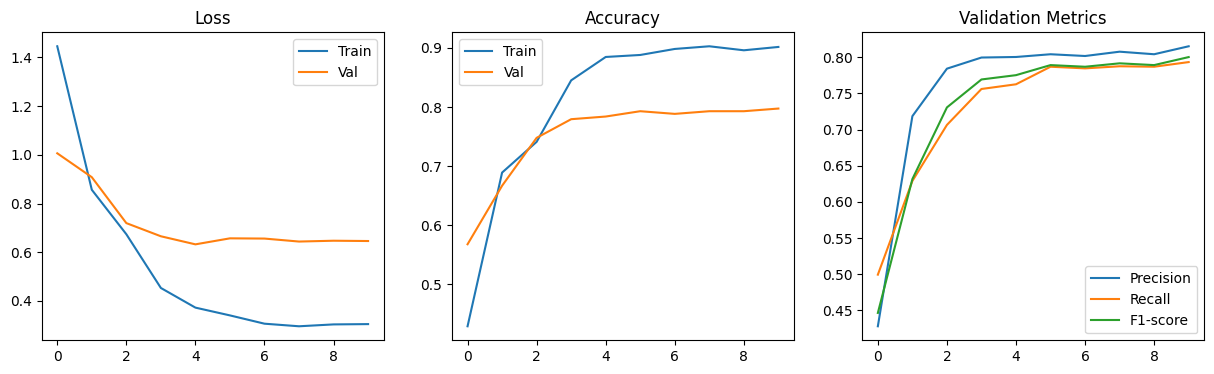

In [15]:
# PLOTS
# =====================================================
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.title("Loss")
plt.legend()

plt.subplot(1,3,2)
plt.plot(train_accs, label="Train")
plt.plot(val_accs, label="Val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,3,3)
plt.plot(precisions, label="Precision")
plt.plot(recalls, label="Recall")
plt.plot(f1s, label="F1-score")
plt.title("Validation Metrics")
plt.legend()

plt.show()